# Feature Engineering

① 환경구성 및 데이터 불러오기
필요 패키지 설치
데이터 불러오기

② Technical Index
데이터셋(시가, 고가, 저가, 종가, 거래량)에서 기술적 지표(추세, 변동성, 거래량, 모멘텀) 적용 데이터셋 생성
새로 만든 데이터셋에서 활용하고자 하는 시점에 대한 수익률, 변화율, 변동성을 적용

③ Feature Selection methods
특성추출(Feature Extraction)과 특성선택(Feature Selection) 중 특성선택을 하는 방법으로 접근하여 어떤 방법론이 있는지 확인해봅시다.

Feature Selection
Sequential Feature Selection
Shapley Additive explanations

분류기의 설명력을 높이고, 성능을 개선하기 위해서 가장 중요한 것은 적절한 Feature를 선택하는 것입니다.
Feature를 선택하는 방식에는 여러 가지 방식이 있으며, 다음 세가지로 크게 분류할 수 있습니다.
Filter Method: Feature들간의 연관성을 찾는 방식(information gain, correlation coefficient 등)
Wrapper Method: 해결하고자 하는 문제에 대한 유용성을 측정하는 방식. Validation set에서의 성능이 최대화되는 Feature Set을 선정 (Recursive Feature Elimination, Sequential Feature Selection 등)
Embedded Method: 훈련의 알고리즘에 Feature 선정과정이 포함되는 방식(Lasso, Ridge, Elastic Net 등)

이 중 Wrapper Method 몇 가지에 대한 사용방법을 알아보고, 이 외에 Prodo 의 저서 'Advances in Financial ML'에서 소개된 방식에 대해 알아보겠습니다. 또한, 주가 모멘텀 포착을 위해 사용할 수 있는 Feature들에는 무엇이 있는지 알아보고, 그 Feature 들 중 어떤 Feature를 선정해야 하는지 여러 방식으로 분석해 보도록 하겠습니다. 마지막으로 'SHAP'이라는 Feature 분석 패키지를 통해 Feature의 중요도를 확인해 보도록 하겠습니다.

# 1. 환경구성 및 데이터 불러오기

① 환경구성
ta, shap 패키지 설치 및 필요 패키지 불러오기

ta : Python Pandas 기반의 금융 시계열 데이터 분석을 지원하는 라이브러리

In [1]:
!pip install ta==0.9.0
!pip install shap

In [2]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [ ]:
② 데이터 불러오기
Feature Engineering을 적용할 데이터셋 불러오기
데이터셋을 불러오는 과정에 있는 Pickle(.pkl)은 Python의 list, class, dictionary와 같은 자료형(type)을 바이너리로 변환하여 파일로 저장된 것을 말합니다. 
일반적으로 파일은 텍스트로 저장되며 파이썬의 자료형은 객체로 저장되는데 객체 상태로는 바로 사용할 수 없기 때문에 
컴퓨터가 이해할 수 있는 바이너리로 저장되어 사용할 수 있습니다.

In [3]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

In [4]:
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [5]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [6]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [7]:
df_label_data.value_counts()

-1.0    306636
-0.0    302963
 1.0    299289
Name: t_value, dtype: int64

# 2. Technical Index

기술적 지표, 수익률/변동성 지표
수익률, 변동성까지 적용된 데이터셋을 표준화(standardization)하고 fit_transform하여 RandomForest에 적용합니다. 아래 Feature Selection을 하기 위한 선행과정입니다.

추세 지표

MACD, Moving Average Convergence/Divergence : 단기 이평선과 장기 이평선의 차이로 주가의 수렴 / 확산 정도를 나타내는 지표, 'signal', 'average', 'diverence'로 구성됨.
ADX, Average Directional Movement : 금일의 주가 움직임의 범위가 전일의 범위를 어느 방향으로 벗어났는지를 관찰, 추세의 강도를 추적하는 지표
TRIX, Triple Exponential : n-영업일 지수가중평균을 3번 연달아 실시한 후, 그 값의 기울기를 나타낸 지표
DPO, detrended price oscillator : 가장 최신의 가격 흐름에 반응하지 않도록 변위된 이동평균을 사용하여, 장기추세를 제거하기 위한 지표. 중기 과매수 / 과매도 정도를 표시
AROON, AROON : 추세의 강도와 변화를 식별하기 위한 지표, 고가사이의 시간차와 저가사이의 시간차를 측정

변동성 지표

ATR, Average True Range : 시장의 변동성을 측정하기 위한 지표, (고가 - 저가), (고가 - 전일종가)의 절대값, (저가 - 전일종가)의 절대값 중 큰값을 취하여, 이동평균
UI, Ulcer Index : 가격 하락의 유지기간, 깊이를 통해 가격의 하락 위험을 측정하는 지표

거래량 지표

CMF, Chaikin Money Flow : 산출방식이 MACD와 유사, 두 accumulation/distribution line의 EMA값의 차이를 통해 돈의 유입/유출을 파악하려는 지표
MFI, Money Flow Index : 가격의 흐름과 거래량의 조합으로 모멘텀의 방향성을 나타내는 지표
FI, Force Index : 가격과 거래량을 사용하여 가격의 움직임을 좌우하는 힘의 강도를 측정하는 지표
SMA EM, Ease of Movement : 가격의 상승/하락을 판단하기 위한 지표. 가격의 변동성과 거래량을 통해 가격 흐름의 용이성을 측정
VPT, Volume Price Trend : 가격의 변화 강도와 그 방향을 나타내는 지표. 수요 / 공급의 균형을 측정

모멘텀 지표

RSI, Relative Strength Index : 가격 흐름의 상대강도를 측정하는 지표. 일정기간 내의 평균 수익과 손실의 강도를 비교함.
WR, Williams %R : 과매도 / 과매수를 측정하는 지표(-100 ~ 0). 진입 / 청산 시점을 포착하는데 사용됨.

In [8]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

/opt/conda/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [9]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


② 수익률 / 변동성 지표

수익률, 변화율 지표
현재가격(종가)과 직전 n-영업일 가격과의 비율: 
금일 거래량과 직전 n-영업일 거래량과의 비율: 
 
변동성 지표
종가의 n-영업일 이동 표준편차
거래량의 n-영업일 이동 표준편차

In [10]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [11]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [12]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [13]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


In [14]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

# 3. Feature Selection methods

특성선택(Feature Selection)을 위한 기법으로 다음과 같은 방법이 있습니다.

① Feature Selection
- MDI
- MDA

② Sequential Feature Selection
- RFE CV
- SFS

③ Shapley Additive explanations
- SHAP

① Feature Selection

MDI, Mean Decrease Impurity
Tree 계열 분류기에서 산출되는 Feature Importance 값을 사용한 Feature Selection 기법입니다.
In-Sample 방식 --> Train Set의 정확도를 기반으로 하기 때문에 In-Sample 이라고 합니다.
모든 Feature가 어느 정도의 중요도를 갖습니다.
모든 Feature Importance 의 총합은 1입니다.
substitution effect를 해결하지 못 합니다.

In [15]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)

In [16]:
feat_imp

,mean,std
volume_cmf,0.050341,0.002273
volume_fi,0.045256,0.002398
volume_mfi,0.046043,0.002513
volume_sma_em,0.035554,0.001893
volume_vpt,0.026509,0.001398
volatility_atr,0.073870,0.002980
volatility_ui,0.046403,0.002155
trend_macd_diff,0.071612,0.003654
trend_adx,0.054591,0.002690
trend_trix,0.066845,0.003269


MDA, Mean Decrease Accuracy

Tree 외의의 분류기에서도 사용가능한 Feature Selection 기법입니다.
OOS(Out-of-Sample) 방식 --> Test Set을 기준으로 정확도를 산출하는 방식이기 때문에 OOS 라고 칭합니다.
Accuracy 이외의 다른 성능지표를 사용할 수 있습니다.
MDI와 마차가지로 substitution effect에서 자유롭지 못 합니다.
MDI와 달리, 모든 Feature가 중요하다고 나오지 않을 수 있습니다.

연산 절차
분류기를 Fitting합니다.
성능지표에 따라 OOS 성능을 측정합니다.
순차적으로 각 피처에 대해서, 무작위로 섞은 후 OOS 성능을 기존값과 비교하는 작업을 전체 Feature에 대해 수행.

In [17]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [18]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

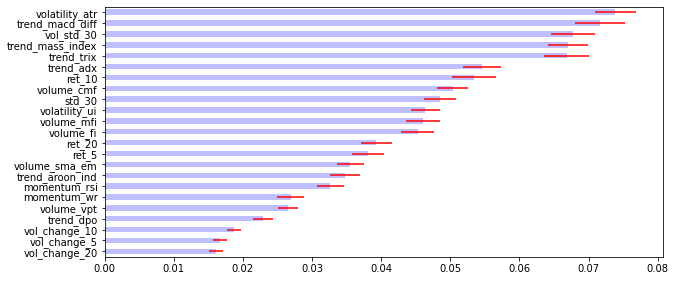

In [19]:
plot_feature_importance(feat_imp)

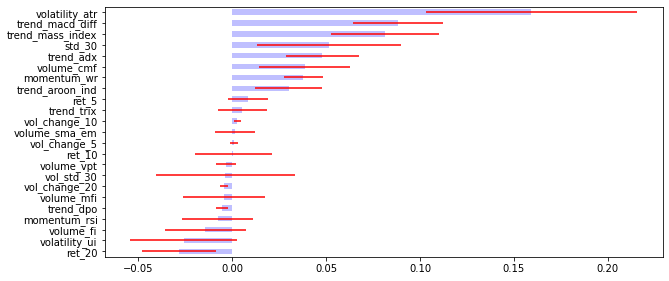

In [20]:
plot_feature_importance(feat_imp_mda)

In [ ]:
② Sequential Feature Selection

RFE CV, Recursive Feature Elimination
RFE방식에 CV를 도입한 기법입니다.
Data Set을 K개로 분할하여 학습과 검증을 동시에 진행하며, 검증시 Feature의 기여도에 따라 삭제 여부를 결정하는 방식을 말합니다.
Validation 성능이 가장 좋은 Feature를 최종 Feature로 결정합니다.

In [21]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [22]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [23]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


SFS, Sequential Feature Selection
순차적으로 Feature를 더하거나 빼는 방식으로 Feature의 최적조합을 찾는 방식입니다.
Backward / Forward 방식 모두 사용할 수 있습니다.
Forward: Null에서 시작하여, Feature를 하나씩 더해가는 방식으로 조합을 찾습니다.
Backwrd: 모든 Feature에서 시작하여 하나씩 빼가는 방식으로 조합을 찾습니다.

In [24]:
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [25]:
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

In [ ]:
③ SHAP, Shapley Additive explanations

게임이론적인 접근방식을 통해 분류기의 출력을 설명하기 위한 기법입니다.
게임이론으로부터 Shapley Value를 추산하여, 이를 바탕으로 Feature를 설명합니다.

Shapley Value란?
게임이론에서 여러명의 플레이어에게 공정한 상벌을 배분하기 위한 솔루션으로써, 여러 플레이어의 공헌도는 서로 상이하지만, 상호간에 이득과 손실을 주고받는 상황에 적용되는 값입니다.
게임 내에서 각 플레이어는 최대의 성과를 얻어내기 위한 의사결정을 연쇄적으로 수행하게 되며 그러한 과정을 통해 얻게 된 게임의 결과에서 해당 플레이어에게 기대할 수 있는 평균적인 한계 공헌도를 Shpely Value라고 합니다.

In [26]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

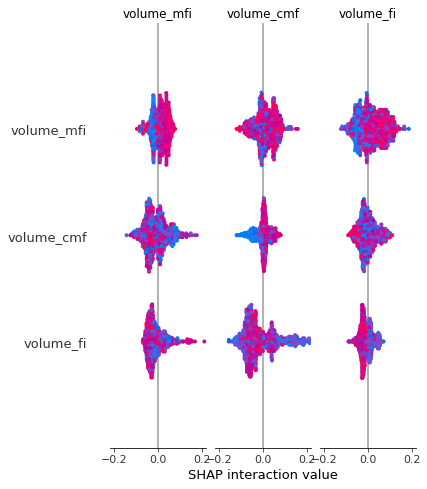

In [30]:
shap.summary_plot(shap_value, X_sc)

In [31]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)